In [1]:
# COVID-19 infections per country
# Copyright 2020 Denis Meyer
# Data source: https://github.com/CSSEGISandData/COVID-19

In [2]:
import logging
import io
import requests
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt

from heapq import nlargest

In [3]:
# Data source
DATA_CSV_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

# Cache file name
CSV_FILENAME = 'time_series_19-covid-Confirmed-{}.csv'

In [4]:
# Ignores file cache if 'True', tries to load data for the current day from file cache otherwise
FORCE_REFRESH_DATA = False

# Boolean flag whether to create a plot containing all countries
PLOT_ALL_COUNTRIES = False # May take some time in the current implementation

# Boolean flag whether to create a plot containing specific countries
PLOT_SPECIFIC_COUNTRIES = False
PLOT_COUNTRIES = ['Germany', 'Spain', 'Italy']

# Boolean flag whether to create a plot containing just the n highest countries
PLOT_HIGHEST_COUNTRIES = True
NR_OF_HIGHEST_COUNTRIES = 10

# Plot configuration
PLOT_SIZE=(20, 10)
PLOT_TITLE = 'COVID-19 infections per country'
PLOT_LABEL_X = 'Date'
PLOT_LABEL_Y = 'Nr of infections'

# Logging configuration
LOGGING_LOGLEVEL = logging.INFO
LOGGING_DATE_FORMAT = '%d-%m-%Y %H:%M:%S'
LOGGING_FORMAT = '[%(asctime)s] [%(levelname)-5s] [%(module)-20s:%(lineno)-4s] %(message)s'

In [5]:
def initialize_logger(loglevel, frmt, datefmt):
    '''Initializes the logger
    
    :param loglevel: The log level
    :param frmt: The log format
    :param datefmt: The date format
    '''
    logging.basicConfig(level=loglevel,
                        format=frmt,
                        datefmt=datefmt)

def download_csv_data(url):
    '''Downloads the data
    
    :param url: The data source URL
    '''
    if not url:
        return None

    s = requests.get(url).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

def get_data(dir_csv, filename_csv, url, force_refresh_data=False):
    '''Retrieves the data, either from file or download
    
    :param dir_csv: The CSV directory
    :param filename_csv: The CSV filename
    :param url: The URL
    :param force_refresh_data: Boolean whether to force refreshing the data
    '''
    df = None

    path_data = os.path.join(csv_dir, 'data')
    if not os.path.exists(path_data):
        os.makedirs(path_data)
    csv_file = os.path.join(path_data, filename_csv)

    file_loaded = False
    try:
        if not force_refresh_data:
            logging.info('Not force refreshing data')
            logging.info('Trying to load from file "{}"'.format(csv_file))
            df = pd.read_csv('{}'.format(csv_file), encoding='utf-8')
            file_loaded = True
            logging.info('Successfully loaded data from file "{}"'.format(csv_file))
        else:
            logging.info('Force refreshing data')
    except FileNotFoundError:
        df = None
    if not file_loaded:
        logging.info('Downloading fresh data from "{}"...'.format(url))
        df = download_csv_data(DATA_CSV_URL)
        logging.info('Trying to save to file "{}"'.format(csv_file))
        df.to_csv('{}'.format(csv_file), encoding='utf-8', index=False)
        logging.info('Successfully saved to file "{}"'.format(csv_file))

    return df

In [6]:
# initialize_logger(LOGGING_LOGLEVEL, LOGGING_DATE_FORMAT, LOGGING_FORMAT)
# Logging + Jupyter is currently not working together (on my machine...)
logging.info = print

In [7]:
csv_dir = os.getcwd()

current_date_str = datetime.date.today().strftime('%Y-%m-%d')
df = get_data(csv_dir, CSV_FILENAME.format(current_date_str), DATA_CSV_URL, force_refresh_data=FORCE_REFRESH_DATA)

# Drop unnecessary columns
df = df.drop(['Province/State', 'Lat', 'Long'], axis=1)

Not force refreshing data
Trying to load from file "C:\Users\deme\Code\py\data\time_series_19-covid-Confirmed-2020-03-20.csv"
Successfully loaded data from file "C:\Users\deme\Code\py\data\time_series_19-covid-Confirmed-2020-03-20.csv"


In [8]:
# Group by Country/Region, sum the values and reset the index
df_grouped_summed = df.groupby('Country/Region').sum().reset_index()
dates = list(df_grouped_summed.columns.values)[1:]
logging.info('Plotting data from {} to {}'.format(dates[0], dates[-1]))

Plotting data from 1/22/20 to 3/19/20


In [9]:
# Plot: All countries

plot_name = 'All countries'

if PLOT_ALL_COUNTRIES:
    logging.info('Plotting "{}"'.format(plot_name))

    countries = df_grouped_summed['Country/Region']

    # Plot
    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    for cr in countries:
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        df_melted.plot(kind='line', x='Date', y='Value', ax=ax, label=cr)

    ax.set_title('{} - {}'.format(PLOT_TITLE, plot_name), loc='center')
    ax.set_xlabel(PLOT_LABEL_X)
    ax.set_ylabel(PLOT_LABEL_Y)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.show()

In [10]:
# Plot: Specific countries

plot_name = 'Specific countries'

if PLOT_SPECIFIC_COUNTRIES:
    logging.info('Plotting "{}"'.format(plot_name))

    countries = PLOT_COUNTRIES

    # Plot
    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    for cr in countries:
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        df_melted.plot(kind='line', x='Date', y='Value', ax=ax, label=cr)

    ax.set_title('{} - {}'.format(PLOT_TITLE, plot_name), loc='center')
    ax.set_xlabel(PLOT_LABEL_X)
    ax.set_ylabel(PLOT_LABEL_Y)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.show()

Plotting "10 Countries with highest infection rates"


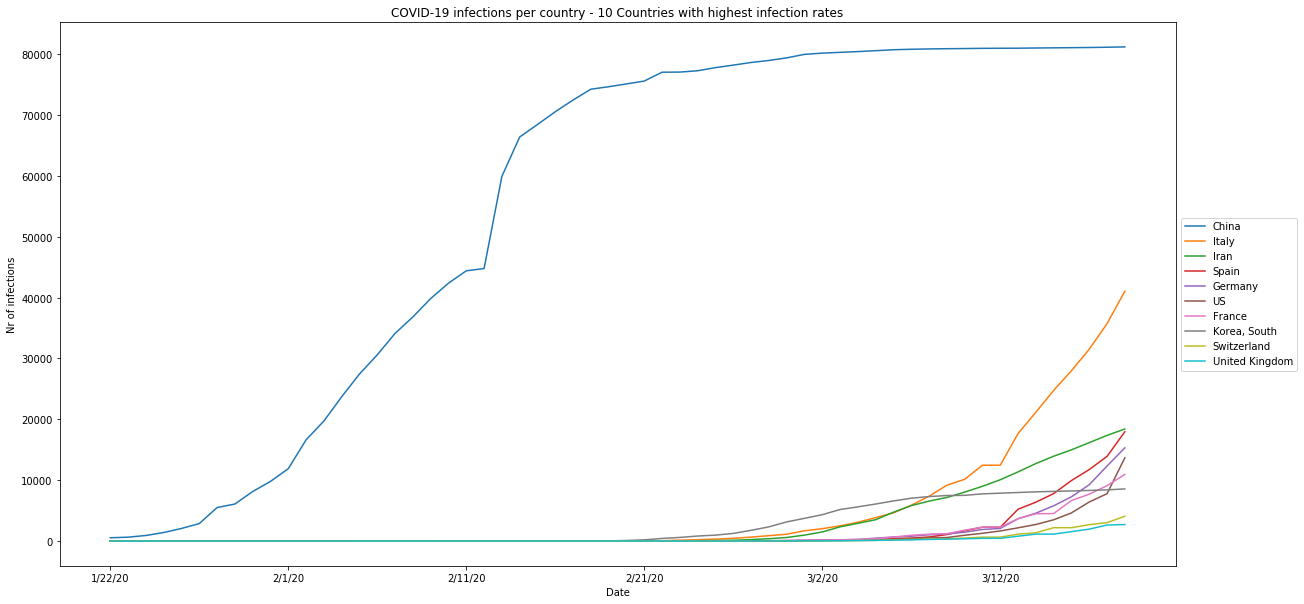

In [11]:
# Plot: Countries with highest infection rates

plot_name = '{} Countries with highest infection rates'.format(NR_OF_HIGHEST_COUNTRIES)

if PLOT_HIGHEST_COUNTRIES:
    logging.info('Plotting "{}"'.format(plot_name))
    
    # Calculate the n highest countries
    dict_highest_all = {}
    countries = df_grouped_summed['Country/Region']
    for cr in countries:
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        dict_highest_all[cr] = df_melted.max().Value

    # Extract the n highest country names
    countries = nlargest(NR_OF_HIGHEST_COUNTRIES, dict_highest_all, key=dict_highest_all.get)

    # Plot
    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    for cr in countries:
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==cr]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        df_melted.plot(kind='line', x='Date', y='Value', ax=ax, label=cr)

    ax.set_title('{} - {}'.format(PLOT_TITLE, plot_name), loc='center')
    ax.set_xlabel(PLOT_LABEL_X)
    ax.set_ylabel(PLOT_LABEL_Y)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()